In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import re
import nltk
import requests
import tkinter as tk
from tkinter import ttk
import ast
from PIL import Image, ImageTk
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [2]:
movies_df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  

In [3]:
movies_df.columns

Index(['Id', 'Original_Title', 'Original_Language', 'Spoken_Languages',
       'Budget', 'Revenue', 'Runtime', 'Release_Date', 'Production_Companies',
       'Production_Countries', 'imdb_id', 'Popularity', 'Vote_Average',
       'Vote_Count', 'Belongs_To_Collection', 'Tagline', 'Overview', 'Genres',
       'Genres_Parse', 'Belongs_To_Collection_Parse', 'Spoken_Languages_Parse',
       'Production_Companies_Parse', 'Production_Countries_Parse',
       'Production_Countries_Code_Parse', 'Keywords', 'Keywords_parse',
       'Cast_parse', 'Director_parse'],
      dtype='object')

In [4]:
movies_df.head(2)

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,...,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']


In [14]:
# Extract unique genres from the dataset
def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genres]
    except:
        return []

# Extract the release year from the release_date column
movies_df['Release_Year'] = pd.to_datetime(movies_df['Release_Date'], errors='coerce').dt.year

all_genres = set()
all_release_years = sorted(movies_df['Release_Year'].dropna().astype(int).unique(), reverse=True)

movies_df['Genres'].dropna().apply(lambda x: all_genres.update(extract_genres(x)))

all_genres = sorted(list(all_genres))

# Initialize the main window
root = tk.Tk()
root.title("Movie Recommender")

# Define the function to show recommendations
def show_recommendations():
    genre = genre_input.get()
    release_year = release_year_input.get()
    keywords = keyword_input.get()
    recommendations = recommend_movies(genre, release_year, keywords)
    result_var.set("\n".join(recommendations))

# Calculate match percentage based on genre, release year, and keywords
def calculate_match_percentage(row, genre, release_year, keywords):
    match_score = 0
    total_criteria = 3  # We have three criteria now: genre, release year, and keywords
    
    # Check genre match
    if genre and genre != "Any":
        if genre in extract_genres(row['Genres']):
            match_score += 1
    
    # Check release year match
    if release_year and release_year != "Any":
        if pd.notna(row['Release_Year']) and row['Release_Year'] == int(release_year):
            match_score += 1
            
    # Check keyword match
    if keywords:
        if pd.notna(row['Overview']) and keywords.lower() in row['Overview'].lower():
            match_score += 1
    
    # Calculate percentage
    return (match_score / total_criteria) * 100

# Recommendation function with percentage calculation
def recommend_movies(genre, release_year, keywords):
    filtered_movies = movies_df
    
    if genre and genre != "Any":
        filtered_movies = filtered_movies[filtered_movies['Genres'].str.contains(genre, case=False, na=False)]
    if release_year and release_year != "Any":
        filtered_movies = filtered_movies[filtered_movies['Release_Year'] == int(release_year)]
    if keywords:
        filtered_movies = filtered_movies[filtered_movies['Overview'].str.contains(keywords, case=False, na=False)]
    
    # Calculate match percentages
    filtered_movies['match_percentage'] = filtered_movies.apply(lambda row: calculate_match_percentage(row, genre, release_year, keywords), axis=1)
    
    # Sort by match percentage and limit to top 5
    filtered_movies = filtered_movies.sort_values(by='match_percentage', ascending=False)
    top_movies = filtered_movies.head(5)[['Original_Title', 'match_percentage']]
    
    # Format the output
    result = [f"{row['Original_Title']} - {row['match_percentage']:.2f}%" for _, row in top_movies.iterrows()]
    return result

# Add a label and dropdown for genre selection
ttk.Label(root, text="Select a genre:").grid(column=0, row=0, padx=10, pady=10)
genre_input = ttk.Combobox(root, values=["Any"] + all_genres)
genre_input.grid(column=1, row=0, padx=10, pady=10)
genre_input.set("Any")

# Add a label and dropdown for release year selection
ttk.Label(root, text="Select a release year:").grid(column=0, row=1, padx=10, pady=10)
release_year_input = ttk.Combobox(root, values=["Any"] + [str(year) for year in all_release_years])
release_year_input.grid(column=1, row=1, padx=10, pady=10)
release_year_input.set("Any")

# Add a label and entry for keyword input
ttk.Label(root, text="Enter keywords:").grid(column=0, row=2, padx=10, pady=10)
keyword_input = ttk.Entry(root)
keyword_input.grid(column=1, row=2, padx=10, pady=10)

# Add a button to trigger recommendation
ttk.Button(root, text="Get Recommendations", command=show_recommendations).grid(column=0, row=3, columnspan=2, padx=10, pady=10)

# Add a label to display the results
result_var = tk.StringVar()
ttk.Label(root, textvariable=result_var).grid(column=0, row=4, columnspan=2, padx=10, pady=10)

# Run the application
root.mainloop()

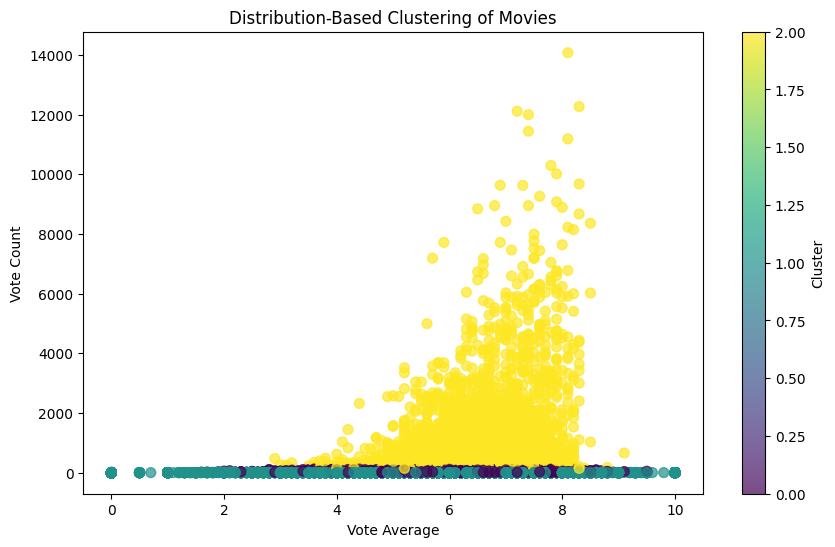

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Filter relevant columns and drop rows with missing values
data = movies_df[['Vote_Average', 'Vote_Count']].dropna()

# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # Assuming 3 clusters, can be adjusted
gmm_labels = gmm.fit_predict(scaled_data)

# Add cluster labels to the original data
data['cluster'] = gmm_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['Vote_Average'], data['Vote_Count'], c=data['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("Distribution-Based Clustering of Movies")
plt.xlabel("Vote Average")
plt.ylabel("Vote Count")
plt.colorbar(label='Cluster')
plt.show()


**GUI MODEL WITH USER INPUT (ACTOR'S NAME)**

In [13]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import ast

# Ensure 'Cast_parse' is in list format and handle any non-list or NaN entries
movies_df['Cast_parse'] = movies_df['Cast_parse'].apply(
    lambda x: eval(x) if isinstance(x, str) else x if isinstance(x, list) else []
)

# Extract genres and ensure they are in the correct format
def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        if isinstance(genres, list):
            return [genre['name'] for genre in genres if 'name' in genre]
        else:
            return []
    except (ValueError, SyntaxError):
        return []

all_genres = set()
movies_df['Genres_Parse'].dropna().apply(lambda x: all_genres.update(extract_genres(x)))

all_genres = sorted(list(all_genres))

# Extract the release year from the release_date column
movies_df['Release_Year'] = pd.to_datetime(movies_df['Release_Date'], errors='coerce').dt.year
all_release_years = sorted(movies_df['Release_Year'].dropna().astype(int).unique(), reverse=True)

# Initialize the main window
root = tk.Tk()
root.title("Movie Recommender")

# Define the function to show recommendations based on actor
def show_actor_recommendations():
    actor_name = actor_input.get().strip().lower()
    filtered_movies = movies_df[movies_df['Cast_parse'].apply(
        lambda cast: any(actor_name == actor.lower().strip() for actor in cast)
    )]
    
    if filtered_movies.empty:
        result_var.set(f"No movies found with actor '{actor_name.title()}'.")
    else:
        filtered_movies_sorted = filtered_movies.sort_values(by='Popularity', ascending=False)
        top_5_filtered_movies = filtered_movies_sorted.head(5)
        
        # Formatting the output
        results = [
            f"Title: {row['Original_Title']}\nVote Average: {row['Vote_Average']}\nPopularity: {row['Popularity']}\n{'-' * 50}" 
            for _, row in top_5_filtered_movies.iterrows()
        ]
        result_var.set("\n\n".join(results))

# Add a label and entry for actor name input
ttk.Label(root, text="Enter Actor's Name:").grid(column=0, row=0, padx=10, pady=10)
actor_input = ttk.Entry(root)
actor_input.grid(column=1, row=0, padx=10, pady=10)

# Add a button to trigger actor-based recommendation
ttk.Button(root, text="Find Movies", command=show_actor_recommendations).grid(column=0, row=1, columnspan=2, padx=10, pady=10)

# Add a label to display the results
result_var = tk.StringVar()
result_label = ttk.Label(root, textvariable=result_var, justify='left')
result_label.grid(column=0, row=2, columnspan=2, padx=10, pady=10)

# Run the application
root.mainloop()


**GUI Model with KNN Model**

In [12]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Assuming the movies_df DataFrame has been loaded and preprocessed with combined features

# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with similarity scores
def get_movie_recommendations_with_similarity(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    similar_movies_indices = indices.flatten()[1:]
    similar_movies_distances = distances.flatten()[1:]
    
    similarity_scores = 1 - similar_movies_distances
    
    # Select only the relevant columns without including the index or any ID
    similar_movies = data.iloc[similar_movies_indices][['Original_Title', 'Original_Language']]
    similar_movies['Similarity_Score'] = similarity_scores
    
    return similar_movies.reset_index(drop=True)  # Reset the index to avoid showing any ID

# Create the GUI application using Tkinter
class MovieRecommenderApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Movie Recommender")
        self.geometry("800x600")  # Window size

        # Label and entry for the movie title
        self.label = ttk.Label(self, text="Enter Movie Title:")
        self.label.pack(pady=10)

        self.movie_entry = ttk.Entry(self, width=50)
        self.movie_entry.pack(pady=5)

        # Button to get recommendations
        self.recommend_button = ttk.Button(self, text="Get Recommendations", command=self.display_recommendations)
        self.recommend_button.pack(pady=10)

        # Frame to hold the top 5 movie recommendations
        self.results_frame = tk.Frame(self)
        self.results_frame.pack(pady=10, fill=tk.BOTH, expand=True)

    def display_recommendations(self):
        # Clear previous recommendations
        for widget in self.results_frame.winfo_children():
            widget.destroy()

        # Get the movie title from the entry
        movie_title = self.movie_entry.get()

        # Get recommendations
        recommendations = get_movie_recommendations_with_similarity(movie_title)

        # Display recommendations
        if isinstance(recommendations, str):
            no_results_label = ttk.Label(self.results_frame, text=recommendations)
            no_results_label.pack()
        else:
            tk.Label(self.results_frame, text=f"Top 5 movies similar to '{movie_title}':", font=('Arial', 14)).pack(pady=5)
            
            for idx, row in recommendations.iterrows():
                details = f"{idx + 1}. {row['Original_Title']} ({row['Original_Language'].upper()}) - Similarity: {row['Similarity_Score']:.2f}"
                details_label = tk.Label(self.results_frame, text=details, font=('Arial', 12))
                details_label.pack(anchor='w', padx=10, pady=5)
                
                # Add a separator line for visual separation
                separator = ttk.Separator(self.results_frame, orient='horizontal')
                separator.pack(fill='x', padx=5, pady=5)

# Run the application
if __name__ == "__main__":
    app = MovieRecommenderApp()
    app.mainloop()
